## CS 109B/STAT 121B/AC 209B/CSCI E-109B: Homework 5
### Neural Net Basics & Feed-forward Nets
** Harvard University ** <br>
** Spring  2018 ** <br>
** Instructors:** Pavlos Protopapas and Mark Glickman 

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

** Your partner's name (if you submit separately): **

** Enrollment Status (109B, 121B, 209B, or E109B): 209B **

In [1]:
import sys

import warnings
warnings.filterwarnings("ignore")

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, BatchNormalization, Dropout
from keras.optimizers import SGD, RMSprop, Adam
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.models import load_model

import numpy as np
import pandas as pd
import time

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


Using TensorFlow backend.


## Learning fractal patterns using neural networks

As discussed in class, feed forward networks can be used to approximate non-linear functions. In this homework you will build different neural networks to approxiamte a particular * function * $f^*(x)$,  that produces the `Sierpinski triangles` (see below), compare it to standard machine learning algorithms, explore different architectures and regularization techniques. The input to this model is a two dimensional position vector, $(x_1, x_2)$, and the response is a binary variable. 

You are provided a dataset with two features and a binary response variable. The training and test samples are provided in the files `fractal_train.txt` and `fractal_test.txt` respectively, and a sample for validation is provided in the file `fractal_vali.txt`.  

The data points lie in a square of dimension 1$\times$1 and form a Sierpinski triangle. A Sierpinski triangle is a fractal pattern that reveals the same triangular pattern across different scales. The following <a href=https://en.wikipedia.org/wiki/Sierpinski_triangle>Wikipedia page</a> has a detailed description of Sierpinski triangles. The label-1 points are distributed uniformly across the fractal pattern, and the label-0 points are distributed uniformly across the entire square.


A Sierpinski triangle can be generated at different depths or *scales*. For example, the following image from Wiki shows Sierpinski triangles generated at scales 0, 1, 2, 3 and 4:
<center>
<img src = "https://upload.wikimedia.org/wikipedia/commons/0/05/Sierpinski_triangle_evolution.svg">
</center>

Notice that the larger the scale, the more difficult it is to model the pattern, making this dataset an ideal candidate to study and understand multilayer feedforward neural networks. In the dataset provided, the Sierpinski triangle has been generated at a scale of 5. We expect  a reasonable classifier for this dataset to be able to yield a classification accuracy of at least 80%. The theoretical best accuracy that can be achieved on this dataset is ~94%. 

The following are the main learning outcomes from this homework:
- Model, train, and evaluate feedforward neural networks in `Keras`
- Explore different network architectures, and analyze how the depth and width of a network effects its performance
- Understand and apply regularization to neural networks
- Compare the performance neural networks with other standard machine learning algorithms

You may use the following function to visualize the decision boundaries of the trained models.

## Part 0: Visualize data (5pts)

1. Read the data and use the `plot_data` from `HW5_functions.py` to visualize the data. `plot_data` takes the following parameters: `plot_data(x, y, ax, title)`, where `x` are the predictors and `y` are the labels.
Your answer should contain two plots: one for the training data, and one for the test data. Each plot should have the axes labeled, contain a title, and a color-coded legend for the positive and negative examples.

In [2]:
# starter code
from HW5_functions import plot_data

In [3]:
# read data
df_train = pd.read_table('fractal_train.txt', sep=',', header=None)
df_test = pd.read_table('fractal_test.txt', sep=',', header=None)
df_vali = pd.read_table('fractal_vali.txt', sep=',', header=None)

# split data into feature and outcome
X_train = df_train.iloc[:, :2].values
Y_train = df_train.iloc[:, 2].values
X_test = df_test.iloc[:, :2].values
Y_test = df_test.iloc[:, 2].values
X_vali = df_vali.iloc[:, :2].values
Y_vali = df_vali.iloc[:, 2].values

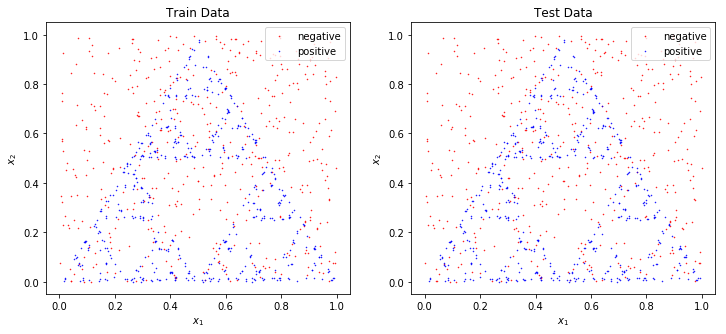

In [4]:
# visualize data
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_data(X_train, Y_train, axes[0], 'Train Data')
plot_data(X_train, Y_train, axes[1], 'Test Data')

## Part 1: Evaluate baselines (10pts) 

1. Fit the following machine learning models to the training sample and evaluate their classification accuracies on the test sample. Use the `sklearn` models that were imported above.
    - Linear Logistic Regression
    - Support Vector Machine (with RBF kernel)
    - Random Forest

2. In each case, visualize the decision boundaries learned by the models using the `plot_decision_boundary` from `HW5_functions`.

Do not forget to tune the relevant hyper-parameters using cross-validation on the training set. The parameters you may consider include the `regularization parameter` in logistic regression, the `regularization parameter` and `kernel width` in SVM and the `maximum tree depth` and `number of estimators` in random forest.

Your answer should include three decision boundary plots (one for each model), with the training and testing classification accuracies for each printed in the title.

In [5]:
# starter code
from HW5_functions import plot_decision_boundary

In [6]:
print("Best Fitted Classifiers:")
## Part 1, your code starts here
# logistic regression
# use default Cs = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]
logistic = LogisticRegressionCV(n_jobs=-1).fit(X_train, Y_train)
logistic_train_acc = logistic.score(X_train, Y_train)
logistic_test_acc = logistic.score(X_test, Y_test)
print("\n=== Logistic Regression === \n", logistic)

# svm
svm_params = {
    'C': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4],
    'gamma': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]
}
svm = GridSearchCV(SVC(), svm_params)
svm.fit(X_train, Y_train)
print("\n=== SVM Classifier === \n", svm.best_params_)
svm_opt = SVC(**svm.best_params_, kernel='rbf', random_state=9001).fit(X_train, Y_train)
svm_train_acc = svm_opt.score(X_train, Y_train)
svm_test_acc = svm_opt.score(X_test, Y_test)


# random forest
rf_params = {
    'n_estimators': [10, 20, 32, 64, 128, 256, 512],
    'max_depth': [None, 2, 4, 8, 20, 40, 100]
}
rf = GridSearchCV(RandomForestClassifier(n_jobs=-1), rf_params)
rf.fit(X_train, Y_train)
print("\n=== Random Forest Classifier === \n", rf.best_params_)
rf_opt = RandomForestClassifier(**rf.best_params_, n_jobs=-1, random_state=9001).fit(X_train, Y_train)
rf_train_acc = rf_opt.score(X_train, Y_train)
rf_test_acc = rf_opt.score(X_test, Y_test)


Best Fitted Classifiers:

=== Logistic Regression === 
 LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

=== SVM Classifier === 
 {'C': 100.0, 'gamma': 100.0}

=== Random Forest Classifier === 
 {'max_depth': 100, 'n_estimators': 512}


In [7]:
print("Train accuracy: ")
print("Logistic Regression: ", logistic_train_acc)
print("SVM Classifier: ", svm_train_acc)
print("Random Forest Classifier", rf_train_acc)
print()
print("Test accuracy: ")
print("Logistic Regression: ", logistic_test_acc)
print("SVM Classifier: ", svm_test_acc)
print("Random Forest Classifier: ", rf_test_acc)

Train accuracy: 
Logistic Regression:  0.612
SVM Classifier:  0.86
Random Forest Classifier 1.0

Test accuracy: 
Logistic Regression:  0.581
SVM Classifier:  0.803
Random Forest Classifier:  0.787


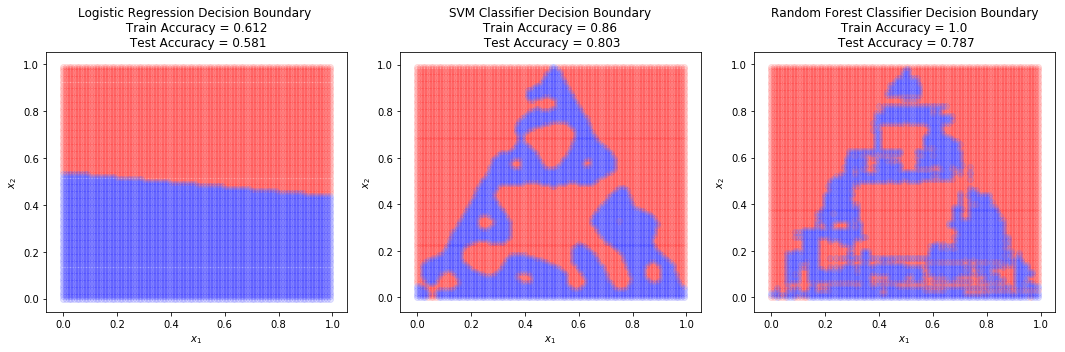

In [8]:
# visualize decision boundaries
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
plot_decision_boundary(X_train, Y_train, logistic, 
                       "Logistic Regression Decision Boundary \n Train Accuracy = {} \n Test Accuracy = {}".format(logistic_train_acc, logistic_test_acc), axes[0])
plot_decision_boundary(X_train, Y_train, svm, 
                       "SVM Classifier Decision Boundary\n Train Accuracy = {} \n Test Accuracy = {}".format(svm_train_acc, svm_test_acc), axes[1])
plot_decision_boundary(X_train, Y_train, rf, 
                       "Random Forest Classifier Decision Boundary\n Train Accuracy = {} \n Test Accuracy = {}".format(rf_train_acc, rf_test_acc), axes[2])
plt.tight_layout()

## Part 2: Train feedforward net with 1 hidden layer (25pts)

1. Fit a feed-forward neural network with a single hidden layer to the training set and evaluate its classification accuracy on the test set. 
2. Using suitable visualizations, explain how the number of nodes in the hidden layer affects the training and test performance of the neural network, and the shape of decision boundary learned by the network.

*Hints:* 
- It is usually recommended that you set the batch size in the optimization algorithm to a power of 2 (can you foresee the benefit of doing this?)
- When we trained a neural network with a single hidden layer of 100 nodes, with ReLU activation functions in the hidden layers, and with the binary cross-entropy as the loss function, we observed a training time of ~2 minutes for 2000 iterations of the Adam solver with learning rate of 0.001 and batch size of 64.
- Use `plot_learning_curve` from `HW5_functions` to visualize the train/test accuracies.

Your answer should fit and evaluate the network for at least two different numbers of nodes in the hidden layer. For each of these different node values, plot a. the decision boundary, and b. the learning curve. Be sure to train your networks until the learning curves demonstrate clear convergence. For \#2, include a brief written explanation of your answer.

In [9]:
import time
from HW5_functions import plot_learning_curve
np.random.seed(9001)

fitting time: 87.50691199302673 s
test loss: 0.4725013117790222
test accuracy: 0.743


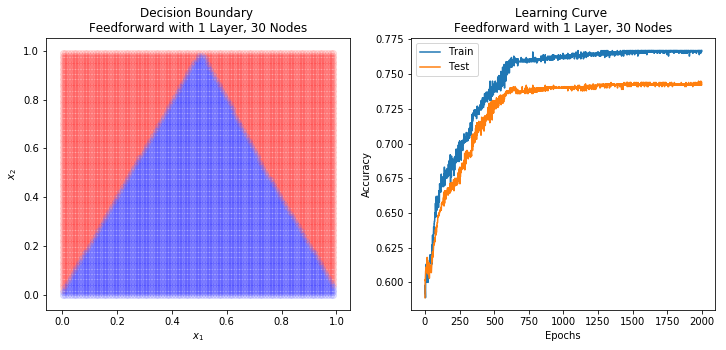

In [10]:
## Part 2, your code starts here
# input dimension
input_dim = 2

# feedforward 1 layer, 30 nodes
ff_1_30 = Sequential()
ff_1_30.add(Dense(30, input_dim=input_dim, activation='relu'))  
# ff_1_30.add(BatchNormalization())
ff_1_30.add(Dense(1, activation='sigmoid')) 
ff_1_30.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

t0 = time.time()
ff_1_30_fit = ff_1_30.fit(X_train, Y_train, batch_size=64, epochs=2000, verbose=0, 
                          validation_data=(X_vali, Y_vali))
t1 = time.time()
print('fitting time: {} s'.format(t1 - t0))

score = ff_1_30.evaluate(X_test, Y_test, verbose=0)
print('test loss: {}'.format(score[0]))
print('test accuracy: {}'.format(score[1]))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_decision_boundary(X_train, Y_train, ff_1_30, 
                       "Decision Boundary \nFeedforward with 1 Layer, 30 Nodes", axes[0])
plot_learning_curve(ff_1_30_fit, axes[1])
axes[1].set_title("Learning Curve \nFeedforward with 1 Layer, 30 Nodes")
plt.show()

fitting time: 89.9176242351532 s
test loss: 0.45746923637390136
test accuracy: 0.757


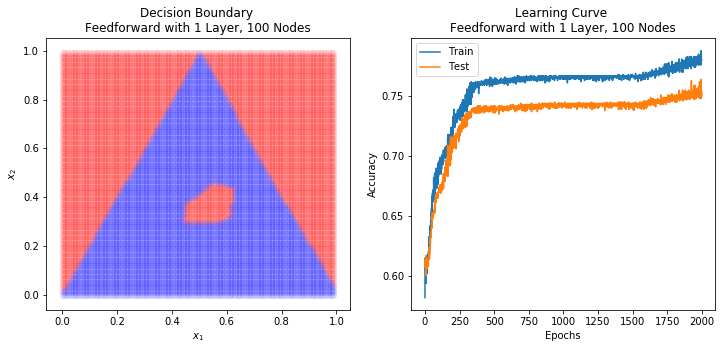

In [11]:
# feedforward 1 layer, 100 nodes
ff_1_100 = Sequential()
ff_1_100.add(Dense(100, input_dim=input_dim, activation='relu'))
ff_1_100.add(Dense(1, activation='sigmoid')) 
ff_1_100.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

t0 = time.time()
ff_1_100_fit = ff_1_100.fit(X_train, Y_train, batch_size=64, epochs=2000, verbose=0, 
                            validation_data=(X_vali, Y_vali))
t1 = time.time()
print('fitting time: {} s'.format(t1 - t0))
score = ff_1_100.evaluate(X_test, Y_test, verbose=0)
print('test loss: {}'.format(score[0]))
print('test accuracy: {}'.format(score[1]))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_decision_boundary(X_train, Y_train, ff_1_100, 
                       "Decision Boundary \nFeedforward with 1 Layer, 100 Nodes", axes[0])
plot_learning_curve(ff_1_100_fit, axes[1])
axes[1].set_title("Learning Curve \nFeedforward with 1 Layer, 100 Nodes")
plt.show()

fitting time: 88.77862000465393 s
test loss: 0.44079544544219973
test accuracy: 0.781


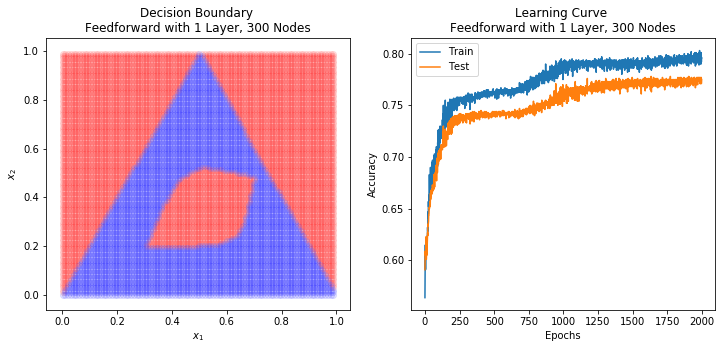

In [12]:
# feedforward 1 layer, 300 nodes
ff_1_300 = Sequential()
ff_1_300.add(Dense(300, input_dim=input_dim, activation='relu'))
ff_1_300.add(Dense(1, activation='sigmoid')) 
ff_1_300.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

t0 = time.time()
ff_1_300_fit = ff_1_300.fit(X_train, Y_train, batch_size=64, epochs=2000, verbose=0, 
                            validation_data=(X_vali, Y_vali))
t1 = time.time()
print('fitting time: {} s'.format(t1 - t0))
score = ff_1_300.evaluate(X_test, Y_test, verbose=0)
print('test loss: {}'.format(score[0]))
print('test accuracy: {}'.format(score[1]))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_decision_boundary(X_train, Y_train, ff_1_300, 
                       "Decision Boundary \nFeedforward with 1 Layer, 300 Nodes", axes[0])
plot_learning_curve(ff_1_300_fit, axes[1])
axes[1].set_title("Learning Curve \nFeedforward with 1 Layer, 300 Nodes")
plt.show()

fitting time: 100.72651982307434 s
test loss: 0.43950613594055177
test accuracy: 0.785


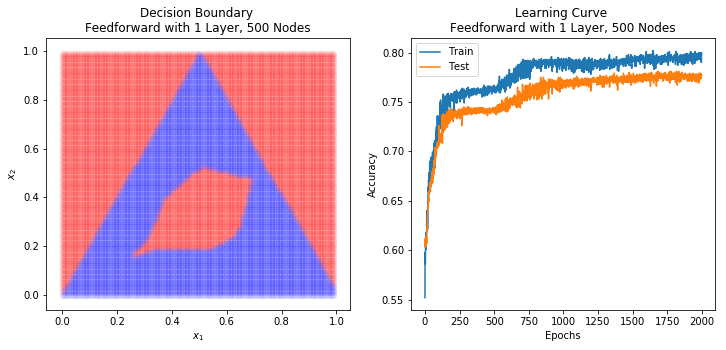

In [13]:
# feedforward 1 layer, 500 nodes
ff_1_500 = Sequential()
ff_1_500.add(Dense(500, input_dim=input_dim, activation='relu')) 
ff_1_500.add(Dense(1, activation='sigmoid')) 
ff_1_500.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])
t0 = time.time()
ff_1_500_fit = ff_1_500.fit(X_train, Y_train, batch_size=64, epochs=2000, verbose=0, 
                            validation_data=(X_vali, Y_vali))
t1 = time.time()
print('fitting time: {} s'.format(t1 - t0))
score = ff_1_500.evaluate(X_test, Y_test, verbose=0)
print('test loss: {}'.format(score[0]))
print('test accuracy: {}'.format(score[1]))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_decision_boundary(X_train, Y_train, ff_1_500, 
                       "Decision Boundary \nFeedforward with 1 Layer, 500 Nodes", axes[0])
plot_learning_curve(ff_1_500_fit, axes[1])
axes[1].set_title("Learning Curve \nFeedforward with 1 Layer, 500 Nodes")
plt.show()

fitting time: 106.08834099769592 s
test loss: 0.43747141790390015
test accuracy: 0.776


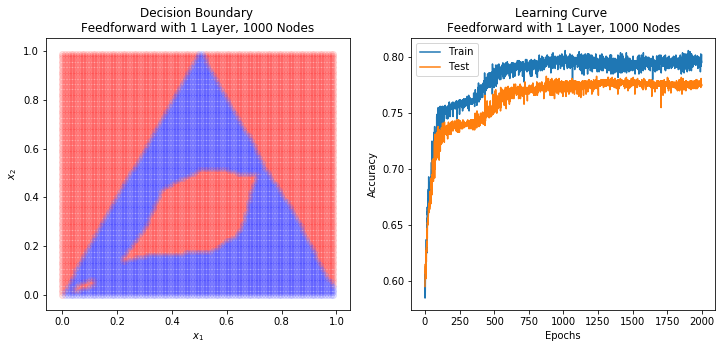

In [14]:
# feedforward 1 layer, 1000 nodes
ff_1_1000 = Sequential()
ff_1_1000.add(Dense(1000, input_dim=input_dim, activation='relu')) 
ff_1_1000.add(Dense(1, activation='sigmoid')) 
ff_1_1000.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])
t0 = time.time()
ff_1_1000_fit = ff_1_1000.fit(X_train, Y_train, batch_size=64, epochs=2000, verbose=0, 
                            validation_data=(X_vali, Y_vali))
t1 = time.time()
print('fitting time: {} s'.format(t1 - t0))
score = ff_1_1000.evaluate(X_test, Y_test, verbose=0)
print('test loss: {}'.format(score[0]))
print('test accuracy: {}'.format(score[1]))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_decision_boundary(X_train, Y_train, ff_1_1000, 
                       "Decision Boundary \nFeedforward with 1 Layer, 1000 Nodes", axes[0])
plot_learning_curve(ff_1_1000_fit, axes[1])
axes[1].set_title("Learning Curve \nFeedforward with 1 Layer, 1000 Nodes")
plt.show()

---
## _Answers_:

It is usually recommended to set the batch size in the optimization algorithm to a power of 2. This allows effective continous memory access, which has the unit of **bit**.

We explored neural networks with one hidden layer and 30, 100, 300 or 500 nodes. Based on the test accuracies and visualizations of the decision boundaries and learning curves, we found that:

- More nodes lead to better training accuracies.
- There exists an optimal number of nodes for the best test accuracy, beyond which the network appears to overfit,leading to reduced test accuracy.
- More nodes lead to more complex decision boundaries.

---

## Part 3: To go deeper or wider? (25pts) 

1. We shall now consider neural network models with more than one hidden layer. Fixing the total number of hidden nodes across all layers to 500, train and evaluate the following network architectures with varying depths:
    - 2 layers with 250 nodes each
    - 3 layers with 166 nodes each
    - 4 layers with 125 nodes each
    - 5 layers with 100 nodes each

2. What is the effect of depth and width of the network on the training and test accuracies? 
3. Based on your observations, what would be a good rule-of-thumb for choosing the appropriate network architecture? Support your answers with suitable visualizations.

*Hint:* When we trained a neural network with 3 hidden layer and 166 nodes in each layer, with ReLU activation functions in the hidden layers, and with the binary cross-entropy as the loss function, we observed a training time of ~6 minutes for ~2000 iterations of the Adam solver with learning rate of 0.001 and batch size of 64.

Your answer should contain 2 plots (decision boundary and learning curve) for each of the four networks. Please indicate in \#2 the trends and behaviors you observe as the parameters change. Using these observations, justify your answer in \#3 with a brief written explanation.

In [15]:
nn_acc_train = []
nn_acc_test = []

In [16]:
## Part 3, your code starts here
input_dim = 2
# feedforward 2 layer, 250 nodes
ff_2_250 = Sequential()
ff_2_250.add(Dense(250, input_dim=input_dim, activation='relu'))
ff_2_250.add(Dense(250, activation='relu'))
ff_2_250.add(Dense(1, activation='sigmoid')) 
ff_2_250.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

t0 = time.time()
ff_2_250_fit = ff_2_250.fit(X_train, Y_train, batch_size=64, epochs=2000, verbose=0, 
                            validation_data=(X_vali, Y_vali))
t1 = time.time()
print('fitting time: {} s'.format(t1 - t0))

fitting time: 158.0512547492981 s


train loss: 0.3690514824390411
train accuracy: 0.828
test loss: 0.45712693881988525
test accuracy: 0.781


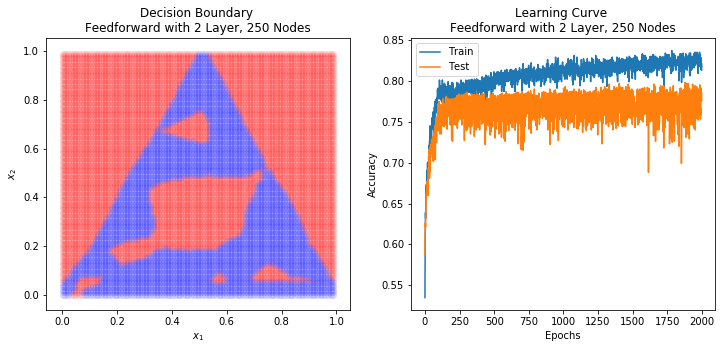

In [17]:
train_score = ff_2_250.evaluate(X_train, Y_train, verbose=0)
print('train loss: {}'.format(train_score[0]))
print('train accuracy: {}'.format(train_score[1]))
score = ff_2_250.evaluate(X_test, Y_test, verbose=0)
print('test loss: {}'.format(score[0]))
print('test accuracy: {}'.format(score[1]))
nn_acc_train.append(train_score[1])
nn_acc_test.append(score[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_decision_boundary(X_train, Y_train, ff_2_250, 
                       "Decision Boundary \nFeedforward with 2 Layer, 250 Nodes", axes[0])
plot_learning_curve(ff_2_250_fit, axes[1])
axes[1].set_title("Learning Curve \nFeedforward with 2 Layer, 250 Nodes")
plt.show()

In [18]:
# feedforward 3 layer, 166 nodes
ff_3_166 = Sequential()
ff_3_166.add(Dense(166, input_dim=input_dim, activation='relu'))
ff_3_166.add(Dense(166, activation='relu'))
ff_3_166.add(Dense(166, activation='relu'))
ff_3_166.add(Dense(1, activation='sigmoid'))
ff_3_166.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

t0 = time.time()
ff_3_166_fit = ff_3_166.fit(X_train, Y_train, batch_size=64, epochs=2000, verbose=0, 
                            validation_data=(X_vali, Y_vali))
t1 = time.time()
print('fitting time: {} s'.format(t1 - t0))

fitting time: 161.74169993400574 s


train loss: 0.2314354511499405
train accuracy: 0.9
test loss: 0.5872014875411987
test accuracy: 0.78


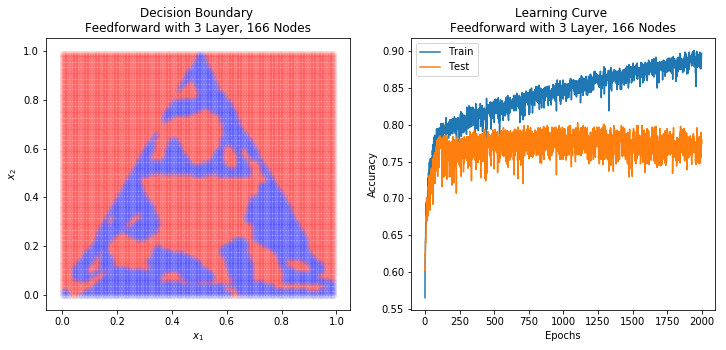

In [19]:
train_score = ff_3_166.evaluate(X_train, Y_train, verbose=0)
print('train loss: {}'.format(train_score[0]))
print('train accuracy: {}'.format(train_score[1]))
score = ff_3_166.evaluate(X_test, Y_test, verbose=0)
print('test loss: {}'.format(score[0]))
print('test accuracy: {}'.format(score[1]))
nn_acc_train.append(train_score[1])
nn_acc_test.append(score[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_decision_boundary(X_train, Y_train, ff_3_166, 
                       "Decision Boundary \nFeedforward with 3 Layer, 166 Nodes", axes[0])
plot_learning_curve(ff_3_166_fit, axes[1])
axes[1].set_title("Learning Curve \nFeedforward with 3 Layer, 166 Nodes")
plt.show()

In [20]:
# feedforward 4 layer, 125 nodes
ff_4_125 = Sequential()
ff_4_125.add(Dense(125, input_dim=input_dim, activation='relu'))
ff_4_125.add(Dense(125, activation='relu'))
ff_4_125.add(Dense(125, activation='relu'))
ff_4_125.add(Dense(125, activation='relu'))
ff_4_125.add(Dense(1, activation='sigmoid')) 
ff_4_125.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

t0 = time.time()
ff_4_125_fit = ff_4_125.fit(X_train, Y_train, batch_size=64, epochs=2000, verbose=0, 
                            validation_data=(X_vali, Y_vali))
t1 = time.time()
print('fitting time: {} s'.format(t1 - t0))

fitting time: 146.95535588264465 s


train loss: 0.13753254693746567
train accuracy: 0.941
test loss: 0.8144281101226807
test accuracy: 0.789


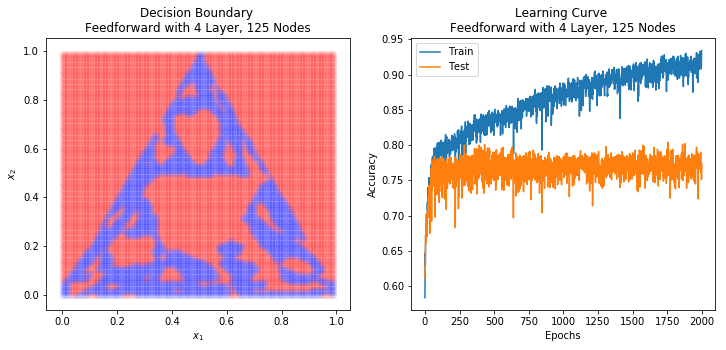

In [21]:
train_score = ff_4_125.evaluate(X_train, Y_train, verbose=0)
print('train loss: {}'.format(train_score[0]))
print('train accuracy: {}'.format(train_score[1]))
score = ff_4_125.evaluate(X_test, Y_test, verbose=0)
print('test loss: {}'.format(score[0]))
print('test accuracy: {}'.format(score[1]))
nn_acc_train.append(train_score[1])
nn_acc_test.append(score[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_decision_boundary(X_train, Y_train, ff_4_125, 
                       "Decision Boundary \nFeedforward with 4 Layer, 125 Nodes", axes[0])
plot_learning_curve(ff_4_125_fit, axes[1])
axes[1].set_title("Learning Curve \nFeedforward with 4 Layer, 125 Nodes")
plt.show()

In [22]:
# feedforward 5 layer, 100 nodes
ff_5_100 = Sequential()
ff_5_100.add(Dense(100, input_dim=input_dim, activation='relu'))
ff_5_100.add(Dense(100, activation='relu'))
ff_5_100.add(Dense(100, activation='relu'))
ff_5_100.add(Dense(100, activation='relu'))
ff_5_100.add(Dense(100, activation='relu'))
ff_5_100.add(Dense(1, activation='sigmoid')) 
ff_5_100.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

t0 = time.time()
ff_5_100_fit = ff_5_100.fit(X_train, Y_train, batch_size=64, epochs=2000, verbose=0, 
                            validation_data=(X_vali, Y_vali))
t1 = time.time()
print('fitting time: {} s'.format(t1 - t0))

fitting time: 140.75175285339355 s


train loss: 0.13263398552685976
train accuracy: 0.948
test loss: 0.9302435870170593
test accuracy: 0.79


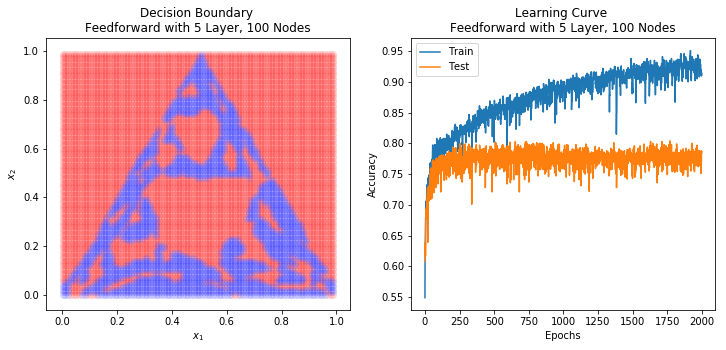

In [23]:
train_score = ff_5_100.evaluate(X_train, Y_train, verbose=0)
print('train loss: {}'.format(train_score[0]))
print('train accuracy: {}'.format(train_score[1]))
score = ff_5_100.evaluate(X_test, Y_test, verbose=0)
print('test loss: {}'.format(score[0]))
print('test accuracy: {}'.format(score[1]))
nn_acc_train.append(train_score[1])
nn_acc_test.append(score[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_decision_boundary(X_train, Y_train, ff_5_100, 
                       "Decision Boundary \nFeedforward with 5 Layer, 100 Nodes", axes[0])
plot_learning_curve(ff_5_100_fit, axes[1])
axes[1].set_title("Learning Curve \nFeedforward with 5 Layer, 100 Nodes")
plt.show()

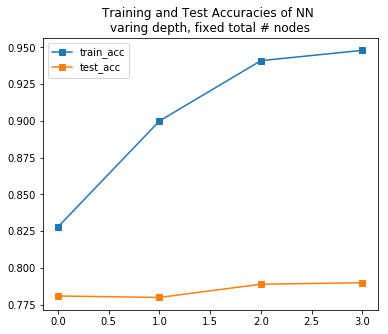

In [24]:
# plot training and test accuracies
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.plot(np.arange(len(nn_acc_train)), nn_acc_train, 's-', label='train_acc')
ax.plot(np.arange(len(nn_acc_test)), nn_acc_test, 's-', label='test_acc')
ax.set_title('Training and Test Accuracies of NN \nvaring depth, fixed total # nodes')
plt.legend()
plt.show()

---
## _Answers_:

Both depth and width can increase model expressiveness, but depth increases model flexibility at a higher rate than width due to a multiplicative increase in feature dimensionality in a completedly connected feedforward neural network architecture.  

Based on our results, we found that neural network with multi-layer architecture (layer = 2, 3, 4, 5) improved training accuracies but not necessarily the test accuracies. This is suggestive of some degree of overfitting, which makes logical sense as increasing network depth increases model flexibility. Overfitting is also evident from the divergence of the training versus test learning curves and more complex decision boundaries. We would expect more training data can reduce overfitting and thus enable a deeper neural network to give better test performance.
 
Based on the plot of training and test accuracies of neural networks (NN) with varying depths but same total parameters, we would suggest building a relatively wide and shallow NN with small training data, but a relatively narrow and deep NN with large training data.

---

## Part 4: Does regularization help? (25pts) 

Let us next explore if the use of regularization techniques can improve the test performance achieved in the previous parts. 
1. Choose a sufficiently complex neural network architecture (two or more hidden layers, and 100 or more nodes per layer), and train the network with one or more regularization techniques of your choice.  You are encouraged to try out different forms of regularization, but it is sufficient that you report results with one of the techniques. Report the training and testing accuracies.
2. Are you able to achieve higher test accuracies than the models learned in parts 1-3? Give a concrete explanation for your observations.

https://keras.io/regularizers/ and https://keras.io/constraints/ contain references to common regularization methods available in Keras.

Your answer should include at least two different regularization attempts (different techniques, parameters, etc.) and contain the decision boundary and learning curve plots for each. In \#2, please explain why regularization might be improving (or hurting) your test accuracy compared to previous models.

### Kernel Regularization - L2, L1

In [25]:
from keras import regularizers
np.random.seed(7001)
input_dim = 2
# Feedfoward with 5 layers, 100 nodes, l2 norm kernel regularization
ff_5_100_l2_reg = Sequential()
ff_5_100_l2_reg.add(Dense(100, input_dim=input_dim, activation='relu', 
                        kernel_regularizer=regularizers.l2(1e-4)))
ff_5_100_l2_reg.add(Dense(100, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
ff_5_100_l2_reg.add(Dense(100, activation='relu', kernel_regularizer=regularizers.l2(1e-4))) 
ff_5_100_l2_reg.add(Dense(100, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
ff_5_100_l2_reg.add(Dense(100, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
ff_5_100_l2_reg.add(Dense(1, activation='sigmoid')) 
ff_5_100_l2_reg.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

t0 = time.time()
ff_5_100_l2_reg_fit = ff_5_100_l2_reg.fit(X_train, Y_train, batch_size=64, epochs=2000, verbose=0, 
                                      validation_data=(X_vali, Y_vali))
t1 = time.time()
print('fitting time: {} s'.format(t1 - t0))

fitting time: 157.05161595344543 s


test loss: 0.7502129874229431
test accuracy: 0.786


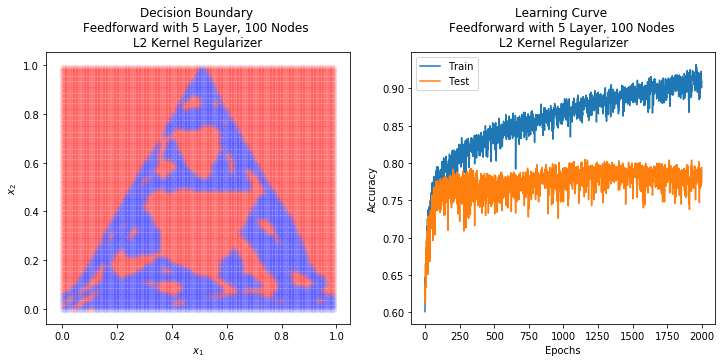

In [26]:
score = ff_5_100_l2_reg.evaluate(X_test, Y_test, verbose=0)
print('test loss: {}'.format(score[0]))
print('test accuracy: {}'.format(score[1]))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_decision_boundary(X_train, Y_train, ff_5_100_l2_reg, 
                       "Decision Boundary \nFeedforward with 5 Layer, 100 Nodes \nL2 Kernel Regularizer", 
                       axes[0])

plot_learning_curve(ff_5_100_l2_reg_fit, axes[1])
axes[1].set_title("Learning Curve \nFeedforward with 5 Layer, 100 Nodes \nL2 Kernel Regularizer")
plt.show()

In [27]:
# Feedfoward with 5 layers, 100 nodes, l1 norm kernel regularization
ff_5_100_l1_reg = Sequential()
ff_5_100_l1_reg.add(Dense(100, input_dim=input_dim, activation='relu', 
                        kernel_regularizer=regularizers.l1(1e-4)))
ff_5_100_l1_reg.add(Dense(100, activation='relu', kernel_regularizer=regularizers.l1(1e-4)))
ff_5_100_l1_reg.add(Dense(100, activation='relu', kernel_regularizer=regularizers.l1(1e-4)))
ff_5_100_l1_reg.add(Dense(100, activation='relu', kernel_regularizer=regularizers.l1(1e-4)))
ff_5_100_l1_reg.add(Dense(100, activation='relu', kernel_regularizer=regularizers.l1(1e-4)))
ff_5_100_l1_reg.add(Dense(1, activation='sigmoid')) 
ff_5_100_l1_reg.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

t0 = time.time()
ff_5_100_l1_reg_fit = ff_5_100_l1_reg.fit(X_train, Y_train, batch_size=64, epochs=2000, verbose=0, 
                                      validation_data=(X_vali, Y_vali))
t1 = time.time()
print('fitting time: {} s'.format(t1 - t0))

fitting time: 144.19493007659912 s


test loss: 0.4649982750415802
test accuracy: 0.8


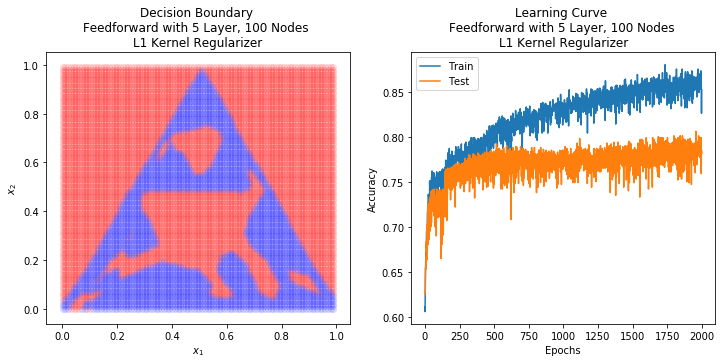

In [28]:
score = ff_5_100_l1_reg.evaluate(X_test, Y_test, verbose=0)
print('test loss: {}'.format(score[0]))
print('test accuracy: {}'.format(score[1]))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_decision_boundary(X_train, Y_train, ff_5_100_l1_reg, 
                       "Decision Boundary \nFeedforward with 5 Layer, 100 Nodes \nL1 Kernel Regularizer", 
                       axes[0])

plot_learning_curve(ff_5_100_l1_reg_fit, axes[1])
axes[1].set_title("Learning Curve \nFeedforward with 5 Layer, 100 Nodes \nL1 Kernel Regularizer")
plt.show()

### Kernel Constraint - max_norm

In [29]:
from keras.constraints import max_norm
# Feedfoward with 5 layers, 100 nodes, max_norm kernal_constraint
ff_5_100_norm_reg = Sequential()
ff_5_100_norm_reg.add(Dense(100, input_dim=input_dim, activation='relu', kernel_constraint=max_norm(3.)))
ff_5_100_norm_reg.add(Dense(100, activation='relu', kernel_constraint=max_norm(3.)))
ff_5_100_norm_reg.add(Dense(100, activation='relu', kernel_constraint=max_norm(3.)))
ff_5_100_norm_reg.add(Dense(100, activation='relu', kernel_constraint=max_norm(3.)))
ff_5_100_norm_reg.add(Dense(100, activation='relu', kernel_constraint=max_norm(3.)))
ff_5_100_norm_reg.add(Dense(1, activation='sigmoid')) 
ff_5_100_norm_reg.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])


t0 = time.time()
ff_5_100_norm_reg_fit = ff_5_100_norm_reg.fit(X_train, Y_train, batch_size=64, epochs=2000, verbose=0, 
                                      validation_data=(X_vali, Y_vali))
t1 = time.time()
print('fitting time: {} s'.format(t1 - t0))

fitting time: 152.64290690422058 s


test loss: 0.7531253771781922
test accuracy: 0.797


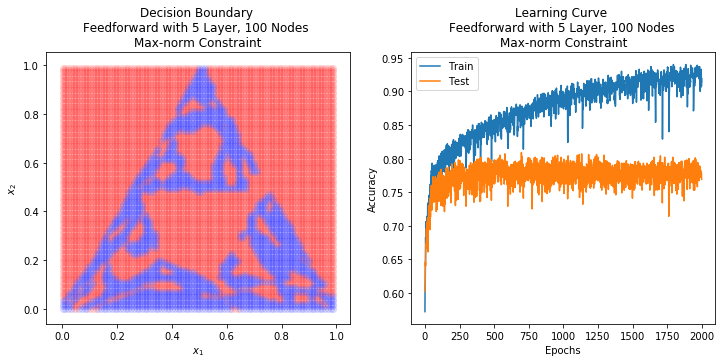

In [30]:
score = ff_5_100_norm_reg.evaluate(X_test, Y_test, verbose=0)
print('test loss: {}'.format(score[0]))
print('test accuracy: {}'.format(score[1]))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_decision_boundary(X_train, Y_train, ff_5_100_norm_reg, 
                       "Decision Boundary \nFeedforward with 5 Layer, 100 Nodes \nMax-norm Constraint", 
                       axes[0])

plot_learning_curve(ff_5_100_norm_reg_fit, axes[1])
axes[1].set_title("Learning Curve \nFeedforward with 5 Layer, 100 Nodes \nMax-norm Constraint")
plt.show()

### Dropout

In [31]:
# Feedfoward with 5 layers, 100 nodes, max_norm kernal_constraint
ff_5_100_dropout = Sequential()
ff_5_100_dropout.add(Dense(100, input_dim=input_dim, activation='relu'))
ff_5_100_dropout.add(Dropout(0.2))

ff_5_100_dropout.add(Dense(100, activation='relu'))
ff_5_100_dropout.add(Dropout(0.2))

ff_5_100_dropout.add(Dense(100, activation='relu'))
ff_5_100_dropout.add(Dropout(0.2))

ff_5_100_dropout.add(Dense(100, activation='relu'))
ff_5_100_dropout.add(Dropout(0.2))

ff_5_100_dropout.add(Dense(100, activation='relu'))
ff_5_100_dropout.add(Dropout(0.2))

ff_5_100_dropout.add(Dense(1, activation='sigmoid')) 
ff_5_100_dropout.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

t0 = time.time()
ff_5_100_dropout_fit = ff_5_100_dropout.fit(X_train, Y_train, batch_size=64, epochs=2000, verbose=0, 
                                      validation_data=(X_vali, Y_vali))
t1 = time.time()
print('fitting time: {} s'.format(t1 - t0))

fitting time: 172.15251183509827 s


test loss: 0.43898722648620603
test accuracy: 0.78


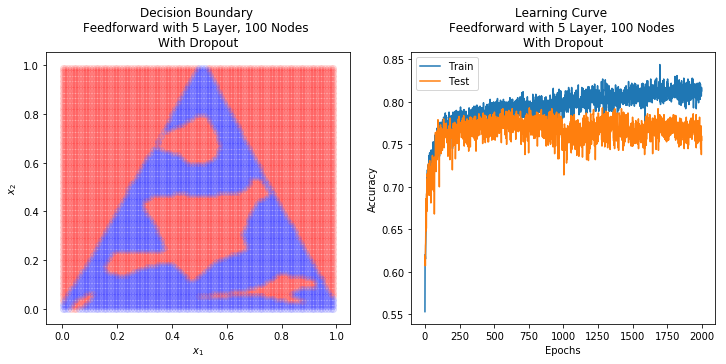

In [32]:
score = ff_5_100_dropout.evaluate(X_test, Y_test, verbose=0)
print('test loss: {}'.format(score[0]))
print('test accuracy: {}'.format(score[1]))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_decision_boundary(X_train, Y_train, ff_5_100_dropout, 
                       "Decision Boundary \nFeedforward with 5 Layer, 100 Nodes \nWith Dropout", 
                       axes[0])

plot_learning_curve(ff_5_100_dropout_fit, axes[1])
axes[1].set_title("Learning Curve \nFeedforward with 5 Layer, 100 Nodes \nWith Dropout")
plt.show()

---
## _Answers_:

We chose the 5-layer, each with 100 nodes NN architecture from the last part, which has shown to have overfitted (traing accuracy $\approx$ 0.95 but test accuracy $\approx$ 0.79). We explored L2/L1 kernel regularizors, max-norm kernel constraint and dropout. None of them significantly improved the models' test accuracies, but L1 kernel regularizor and dropout reduced overffiting, as evident by the reduced difference between the training and test learning curves. 

Regularization cannot significantly improve test performance because there is no noise in the training data. The lack of noise is due to the fact that the optimal decision boundary is invariant between training and test sets as the data points come from exactly the same Sierpinski triangle's fractal geometry. Therefore, the overfitting that we observed did not come from model overfitting to data noise but rather we don't have enough data to complete parameter (NN weights and bias) optimization. The best way to further reduce the generalization error is to have more training data.

---

## Part 5: In-class Kaggle competition (10pts)

The final part of this homework is an in-class Kaggle contest, where you shall compete amongst yourselves to train the best neural network model for modeling Sierpinski fractals.

You may download the test set and submit the predictions through the link:
https://www.kaggle.com/c/learning-sierpinski-triangles/

Throughout the competition, the leader board in the above link will display the performance of your model on a random subset of the test set, while the final evaluation would be based on the performance of your model on the remaining portion of the test set.

You will be awarded points based on the final accuracy of your model on the held-out portion of the test set. If you are one among the top 10 entries on the final leader board and have a 92% accuracy or higher, you will receive 10 points. Otherwise you will be awarded points as follows (we will round up):

- > 91%: 8 points
- 90-91%: 7 points
- 88-89%: 6 points
- 80-87%: 5 points 
- 50-79%: 3 points
- 10-49%: 1 point

 The function `generate_fractals(n, m)` in the code below allows you to generate unlimited fractal data at any desired scale.

In [ ]:
#--------  generate_fractals
# A function to generate 'n' Sierpinski fractal data points at scale 'm'
# Input: 
#      n (number of data points)
#      m (scale to which the Sierpinski is generated)
# Ouput:
#      n x 3 data set (covariates, labels)

def generate_fractals(n, m):
    # Initial triangle vertices
    v1 = [0,0]
    v2 = [1,0]
    v3 = [.5, 0.99]

    npos = int(np.ceil(n/2.))
    nneg = int(np.floor(n/2.))
    
    # Generate npos positive points over fractal
    posdata = np.zeros((npos,3))
    for i in range(npos):
        curr_point = pick_point(v1, v2, v3, m)

        posdata[i,0] = curr_point[0]
        posdata[i,1] = curr_point[1]
        posdata[i,2] = 1

    # Generate nneg positive points over entire square
    negdata = np.random.rand(nneg,2)
    negdata = np.append(negdata, np.zeros((nneg,1)), axis=1)

    # Combine positive and negative points
    data = np.append(posdata, negdata, axis=0)

    # Return permuted data set
    perm = np.random.permutation(n)
    return data[perm, :]


# Function to compute the midpoint of two points
def midpoint(point1, point2):
    return [(point1[0] + point2[0])/2., (point1[1] + point2[1])/2.]


# Function to compute the center of a triangle based on proportions alpha1, alpha2 and alpha3
def center(vertex1, vertex2, vertex3, alpha1, alpha2, alpha3):
    return [alpha1*vertex1[0] + alpha2*vertex2[0] + alpha3*vertex3[0],\
                   alpha1*vertex1[1] + alpha2*vertex2[1] + alpha3*vertex3[1]]


# Function to draw a random point from a Sierpinski triangle at scale 'n'
def pick_point(vertex1, vertex2, vertex3, n):
    if n == 0:
        alpha1 = np.random.rand()
        alpha2 = np.random.rand()
        alpha3 = np.random.rand()
        tot = alpha1 + alpha2 + alpha3
        return center(vertex1, vertex2, vertex3, alpha1/tot, alpha2/tot, alpha3/tot)
    else:
        val = np.random.randint(0,3)
        if val == 0:
            return pick_point(vertex1, midpoint(vertex1, vertex2), midpoint(vertex1, vertex3), n-1)
        elif val == 1:
            return pick_point(midpoint(vertex2, vertex1), vertex2, midpoint(vertex2, vertex3), n-1)
        else:
            return pick_point(midpoint(vertex3, vertex1), midpoint(vertex3, vertex2), vertex3, n-1)

Your classifier will be evaluated based on its classification accuracy on a fractal pattern of scale 10. Note that this pattern is more intricate than the one modeled in parts 1-4. The theoretical best accuracy for a scale-10 pattern is ~98%.

You are free to explore different network architectures, activation functions, optimization algorithms, and regularization techniques, and to tune one or more of the hyperparameters such as the learning rate, batch size, etc.

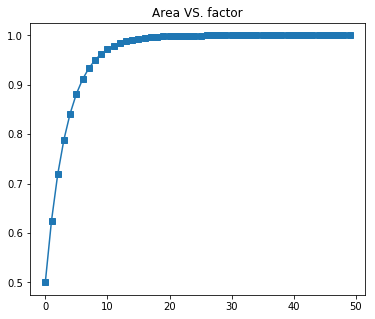

In [35]:
xlin = np.arange(50) 
y = np.array([(0.5 + 0.5*(1-0.75**x)) for x in xlin])
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.plot(xlin, y, 's-')
ax.set_title('Area VS. factor')
plt.show()

Below is the code we used for training. We submitted our fitted keras model to canvas. 

Our Kaggle submissions were made under team-name: **mibabajiabaobao**

In [ ]:
# training data
data_train = generate_fractals(10000000, 10)
# np.save('kaggle_data/data_train_large', data_train)
# data_train = np.load('kaggle_data/data_train_large.npy')
mask = np.random.choice(len(data_train), size=10000000, replace=False)
X_train = data_train[mask, :2]
Y_train = data_train[mask, 2]

# validation data
data_test_10 = generate_fractals(100000, 10)
X_vali = data_test_10[:, :2]
Y_vali = data_test_10[:, 2]

In [ ]:
# Feedfoward with 5 layers, 100 nodes, max_norm kernal_constraint
input_dim = 2
model = Sequential()
model.add(Dense(32, input_dim=input_dim, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid')) 
model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

t0 = time.time()
model_fit = model.fit(X_train, Y_train, batch_size=1000, epochs=200, verbose=1, 
                                      validation_data=(X_vali, Y_vali))
t1 = time.time()
print('fitting time: {} s'.format(t1 - t0))

In [ ]:
score = model.evaluate(X_vali, Y_vali, verbose=0)
print('validation loss: {}'.format(score[0]))
print('validation accuracy: {}'.format(score[1]))

# save model for sequential training
model.save('kaggle_data/models/my_model_seq.h5')

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_decision_boundary(X_vali, Y_vali, model, 
                       "Decision Boundary \nNN - Kaggle", 
                       axes[0])

plot_learning_curve(model_fit, axes[1])
axes[1].set_title("Learning Curve \nNN - Kaggle")
plt.show()

In [ ]:
# load previously fitted model
model_seq = load_model('kaggle_data/models/my_model_seq_large.h5')

In [ ]:
# write predictions
X_test = pd.read_table('kaggle_data/test_predictors.txt', sep=',', header=None)
Y_pred_test = model.predict_classes(X_test)
test_prediction = pd.DataFrame()
test_prediction['index'] = np.arange(len(Y_pred_test)).astype(int) + 1
test_prediction['label'] = Y_pred_test.astype(int)
test_prediction.head()

### For AC209B please look ac209b_hw5.ipynb file